In [33]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf

In [34]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask',
                    'u_component_of_wind_10m_above_ground',
                    'v_component_of_wind_10m_above_ground',
                    'temperature_2m_above_ground',
                    'precipitable_water_entire_atmosphere'
                    ]

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.1298, 7.8760, -0.0053, 2.6823),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.5304, 1.7398051, 4.4828),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.3298, 72.5985),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.9489, 281.08768, 8.9824),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.0923, 295.17383, 9.8155),
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.0243, 3.8501, 1.4110),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.2489, 37.3263, 20.8460),
    # Population
    # min, 99.9 percentile
    'population': (0., 2534.0630, 25.5314, 154.7233),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'u_component_of_wind_10m_above_ground': (-0.1272, 1.4860, 0.6746, 0.3910),
    'v_component_of_wind_10m_above_ground': (-0.6535, 0.9800, 0.1719, 0.3948),
    'temperature_2m_above_ground': (15.2312, 18.6066, 16.9189, 0.8326),
    'precipitable_water_entire_atmosphere': (16.0138, 18.7311, 17.3379, 0.6677),
    'FireMask': (-1., 1., 0., 1.),
}

In [35]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [36]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '[a-zA-Z]+'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError(
      f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def map_fire_labels(labels):
  """Remaps the raw MODIS fire labels to fire, non-fire, and uncertain.

  The raw fire labels have values spanning from `1` to `9`, inclusive.
  https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MYD14A1
  `1`, `2`, `4`, `6` correspond to uncertain labels.
  `3`, `5` correspond to non-fire labels.
  `7`, `8`, `9` correspond to fire labels.

  Args:
    labels: Raw fire labels.

  Returns:
    Labels with values `1` for fire, `0` for non-fire, and `-1` for uncertain.
  """
  non_fire = tf.where(
      tf.logical_or(tf.equal(labels, 3), tf.equal(labels, 5)),
      tf.zeros_like(labels), -1 * tf.ones_like(labels))
  fire = tf.where(tf.greater_equal(labels, 7), tf.ones_like(labels), non_fire)
  return tf.cast(fire, dtype=tf.float32)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  print("Order of parsed input features:")
  for i, key in enumerate(input_features):
      print(f"{i}: {key}")
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  print("inputs_stacked shape:", inputs_stacked.shape)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if 'FireMask' in output_features:
      output_img = map_fire_labels(output_img)
  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [37]:
file_pattern="./data/data_full_train*"

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=len(INPUT_FEATURES),
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Order of parsed input features:
0: elevation
1: th
2: vs
3: tmmn
4: tmmx
5: sph
6: pr
7: pdsi
8: NDVI
9: population
10: erc
11: PrevFireMask
12: u_component_of_wind_10m_above_ground
13: v_component_of_wind_10m_above_ground
14: temperature_2m_above_ground
15: precipitable_water_entire_atmosphere
inputs_stacked shape: (16, 64, 64)


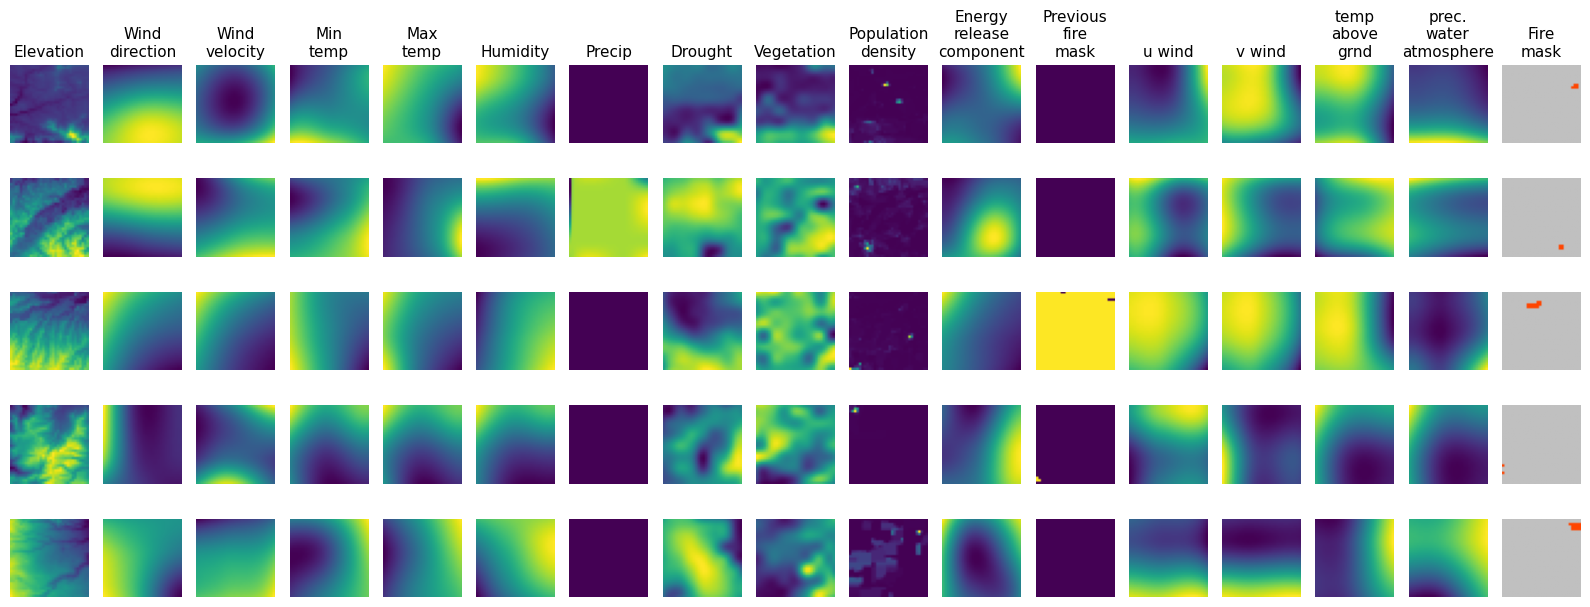

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

#sample a batch
inputs, labels = next(iter(dataset))

#plot
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'u wind',
    'v wind',
    'temp\nabove\ngrnd',
    'prec.\nwater\natmosphere',
    'Fire\nmask'
]

CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

n_rows = 5
n_inputs = inputs.shape[-1]
fig = plt.figure(figsize=(16, 6.5))

for i in range(n_rows):
    for j in range(n_inputs + 1):  #16 input channels, 1 output channel
        plt.subplot(n_rows, n_inputs + 1, i * (n_inputs + 1) + j + 1)
        
        #titles for top
        if i == 0:
            plt.title(TITLES[j], fontsize=11)

        if j < n_inputs:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        else:
            plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)

        plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
raw_dataset = tf.data.TFRecordDataset("./data/data_full_train__000.tfrecord")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    print("Available feature keys:")
    for key in example.features.feature.keys():
        print("-", key)


Available feature keys:
- elevation
- population
- pdsi
- pr
- sph
- u_component_of_wind_10m_above_ground
- th
- PrevFireMask
- erc
- NDVI
- FireMask
- vs
- temperature_2m_above_ground
- tmmx
- precipitable_water_entire_atmosphere
- v_component_of_wind_10m_above_ground
- tmmn


2025-04-24 00:32:08.473891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
import tensorflow as tf
import glob

tfrecord_paths = sorted(glob.glob('./data/data_full_train*.tfrecord'))

missing_prevfiremask = []

for tfrecord_path in tfrecord_paths:
    print(f"🔍 Scanning {tfrecord_path}")
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    for i, raw_example in enumerate(dataset):
        example = tf.train.Example()
        example.ParseFromString(raw_example.numpy())

        if "PrevFireMask" not in example.features.feature:
            print(f"❌ Missing PrevFireMask in {tfrecord_path}, record #{i}")
            missing_prevfiremask.append((tfrecord_path, i))
        else:
            # Optional: print shape or a few values
            values = example.features.feature["PrevFireMask"].float_list.value
            if len(values) == 0:
                print(f"⚠️ Empty PrevFireMask in {tfrecord_path}, record #{i}")
                missing_prevfiremask.append((tfrecord_path, i))

print(f"\n🚨 Total records missing PrevFireMask: {len(missing_prevfiremask)}")

🔍 Scanning ./data/data_full_train__000.tfrecord


2025-04-24 22:23:30.330192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__001.tfrecord


2025-04-24 22:23:31.237065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__002.tfrecord
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #0
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #1
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #2
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #3
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #4
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #5
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #6
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #7
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #8
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #9
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #10
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord, record #11
❌ Missing PrevFireMask in ./data/data_full_train__002.tfrecord

2025-04-24 22:23:32.002696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__003.tfrecord


2025-04-24 22:23:32.560293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__004.tfrecord


2025-04-24 22:23:33.164234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__005.tfrecord


2025-04-24 22:23:33.852678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__006.tfrecord


2025-04-24 22:23:34.550158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__007.tfrecord


2025-04-24 22:23:35.072440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__008.tfrecord


2025-04-24 22:23:35.589024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__009.tfrecord


2025-04-24 22:23:36.078318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__010.tfrecord


2025-04-24 22:23:36.563343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__011.tfrecord
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #300
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #301
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #302
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #303
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #304
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #305
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #306
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #307
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #308
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #309
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #310
❌ Missing PrevFireMask in ./data/data_full_train__011.tfrecord, record #311
❌ Missing PrevFireMask in ./data/data_fu

2025-04-24 22:23:37.104621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__012.tfrecord


2025-04-24 22:23:37.619176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__013.tfrecord


2025-04-24 22:23:38.117245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__014.tfrecord


2025-04-24 22:23:38.615986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__015.tfrecord


2025-04-24 22:23:39.114275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__016.tfrecord


2025-04-24 22:23:39.625512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__017.tfrecord


2025-04-24 22:23:40.112564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__018.tfrecord


2025-04-24 22:23:40.635614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__019.tfrecord


2025-04-24 22:23:41.145674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__020.tfrecord


2025-04-24 22:23:41.901940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__021.tfrecord


2025-04-24 22:23:42.398703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__022.tfrecord


2025-04-24 22:23:42.896007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__023.tfrecord


2025-04-24 22:23:43.465192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__024.tfrecord


2025-04-24 22:23:43.968323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__025.tfrecord


2025-04-24 22:23:44.528176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__026.tfrecord


2025-04-24 22:23:45.036765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__027.tfrecord


2025-04-24 22:23:45.592937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__028.tfrecord
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1804
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1805
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1806
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1807
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1808
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1809
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1810
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1811
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1812
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1813
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1814
❌ Missing PrevFireMask in ./data/data_full_train__028.tfrecord, record #1815
❌ Missing PrevFireMask in ./

2025-04-24 22:23:46.169633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-24 22:23:46.677772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__030.tfrecord


2025-04-24 22:23:47.181299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__031.tfrecord
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #660
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #661
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #662
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #663
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #664
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #665
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #666
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #667
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #668
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #669
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #670
❌ Missing PrevFireMask in ./data/data_full_train__031.tfrecord, record #671
❌ Missing PrevFireMask in ./data/data_fu

2025-04-24 22:23:47.700140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__032.tfrecord


2025-04-24 22:23:48.206179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


🔍 Scanning ./data/data_full_train__033.tfrecord

🚨 Total records missing PrevFireMask: 240


2025-04-24 22:23:48.695684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
